In [2]:
!pip install yfinance

     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/3.0 MB 1.3 MB/s eta 0:00:03
     -- ------------------------------------- 0.2/3.0 MB 2.4 MB/s eta 0:00:02
     ------------- -------------------------- 1.0/3.0 MB 7.9 MB/s eta 0:00:01
     ------------------------------------- -- 2.8/3.0 MB 16.3 MB/s eta 0:00:01
     ---------------------------------------  3.0/3.0 MB 17.5 MB/s eta 0:00:01
     ---------------------------------------- 3.0/3.0 MB 13.8 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/108.7 kB ? eta -:--:--
   ---------------------------------------- 108.7/108.7 k

# Import Libraries

In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

# importing data directly from Yahoo Finance historical values

In [ ]:


# Set a random seed to ensure that our results are reproducible.
# This means that every time you run your code, the random numbers generated (for example, during model initialization)
# will be the same, allowing you to consistently reproduce the same results.
np.random.seed(42)

# Define the stock ticker symbol for Tesla (TSLA)
ticker = 'TSLA'

# Download historical stock data for Tesla for the past 5 years using yfinance.
# The yf.download() function retrieves various data fields (like Open, High, Low, Close, Volume) for the specified period.
data = yf.download(ticker, period='5y')

# Print the shape of the downloaded data to confirm its dimensions (number of rows and columns).
print("Data shape:", data.shape)

# Display the first few rows of the DataFrame to inspect the data and ensure it has been downloaded correctly.
data.head()

# We are interested in predicting the closing price of TSLA.
# Extract the 'Close' column from the DataFrame and reshape it to a two-dimensional array (required by many scikit-learn functions).
prices = data['Close'].values.reshape(-1, 1)

# Neural networks generally perform better when input data is scaled.
# Here, we create a MinMaxScaler to scale the closing prices so that all values fall within the range 0 to 1.
# This scaling helps the training process converge faster and more reliably.
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

In [ ]:
# Define a function to create input sequences and corresponding targets from the time series data.
def create_sequences(data, window_size):
    """
    This function converts a time series into sequences of a fixed window size.
    Each sequence (X) consists of 'window_size' consecutive data points,
    and the target (y) is the data point immediately following that sequence.
    
    Parameters:
      - data: The scaled time series data (a 2D NumPy array).
      - window_size: The number of time steps to include in each input sequence.
      
    Returns:
      - X: NumPy array of input sequences.
      - y: NumPy array of targets corresponding to each sequence.
    """
    # Initialize empty lists to store sequences and targets.
    X = []  # List to hold input sequences
    y = []  # List to hold corresponding targets
    
    # Loop through the data, stopping at a point that allows a full sequence of the given window size
    for i in range(len(data) - window_size):
        # For each iteration, slice the data array to create a sequence of 'window_size' data points.
        # data[i:i+window_size, 0] extracts a sequence starting at index 'i' and spanning 'window_size' steps.
        X.append(data[i:i+window_size, 0])
        
        # The target value (y) is the data point immediately after the current sequence.
        y.append(data[i+window_size, 0])
        
    # Convert the lists of sequences and targets into NumPy arrays for efficient processing.
    return np.array(X), np.array(y)

# Set the window size to 60, meaning each input sequence will contain 60 consecutive time steps.
# For example, the model will use the data from the past 60 days to predict the next day's value.
window_size = 60

# Call the function to create sequences and targets from the scaled price data.
# 'scaled_prices' is our preprocessed dataset (with values scaled between 0 and 1).
X, y = create_sequences(scaled_prices, window_size)


# Pre-process Data

In [7]:
# Calculate the index to split the dataset into training and testing portions.
# We use 80% of the data for training and the remaining 20% for testing.
split = int(0.8 * len(X))

# Use array slicing to separate the input sequences and their corresponding targets:
# - X_train and y_train will contain the first 80% of the data.
# - X_test and y_test will contain the remaining 20%.
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Neural network models such as LSTM require input data to be in a specific 3-dimensional format:
# [samples, time steps, features]
# Currently, our data (X_train and X_test) is in a 2D shape (samples, time steps).
# We reshape it to add a third dimension representing the single feature per time step.
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Print the shapes of the training and testing sets to confirm the dimensions.
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (957, 60, 1)
Test set shape: (240, 60, 1)


# Model Build + Compile

In [ ]:
# Build the Recurrent Neural Network (RNN) model using LSTM layers with the Sequential API.
# The model architecture is designed to process sequences of data and predict future values.

# Create a Sequential model where layers are added one after another.
model = Sequential([
    # First LSTM layer with 50 units.
    # 'return_sequences=True' ensures that the full sequence of outputs is passed to the next layer,
    # which is necessary when stacking LSTM layers.
    # 'input_shape=(window_size, 1)' specifies the shape of the input data: 
    # 'window_size' time steps and 1 feature per time step.
    LSTM(50, return_sequences=True, input_shape=(window_size, 1)),
    
    # Dropout layer with a rate of 0.2.
    # This layer randomly sets 20% of the input units to 0 during training, which helps prevent overfitting.
    Dropout(0.2),
    
    # Second LSTM layer with 50 units.
    # 'return_sequences=False' means this layer outputs only the last value in the sequence,
    # which is appropriate for producing a final prediction.
    LSTM(50, return_sequences=False),
    
    # Another Dropout layer to further reduce overfitting by randomly dropping 20% of the neurons.
    Dropout(0.2),
    
    # A Dense (fully connected) layer with 25 neurons and a ReLU activation function.
    # This layer helps in learning complex patterns after the LSTM layers.
    Dense(25, activation='relu'),
    
    # The final Dense layer with 1 neuron to output the predicted value (e.g., the closing price).
    Dense(1)
])

# Compile the model with the Adam optimizer and mean squared error loss.
# Adam is chosen for its efficiency in handling noisy gradients,
# and mean squared error is a common loss function for regression tasks.
model.compile(optimizer='adam', loss='mean_squared_error')

# Display the model summary to show the architecture and the number of parameters at each layer.
model.summary()


# Train the model

In [ ]:
# Setup Early Stopping to prevent overfitting.
# EarlyStopping monitors the validation loss during training.
# If the validation loss does not improve for 10 consecutive epochs ('patience'=10),
# training will stop, and the best weights encountered during training will be restored.
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model using the training data.
# Here, we specify:
# - 'epochs=50': The maximum number of training iterations over the entire dataset.
# - 'batch_size=32': The number of samples processed before updating the model's weights.
# - 'validation_split=0.1': 10% of the training data is set aside for validating the model during training.
# - 'callbacks=[early_stop]': This list includes our EarlyStopping callback.
# - 'verbose=1': This setting enables progress messages during training.
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)


# Visual - require explanation and based on those reshape the model

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0011  
Test Loss: 0.0016602545510977507
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


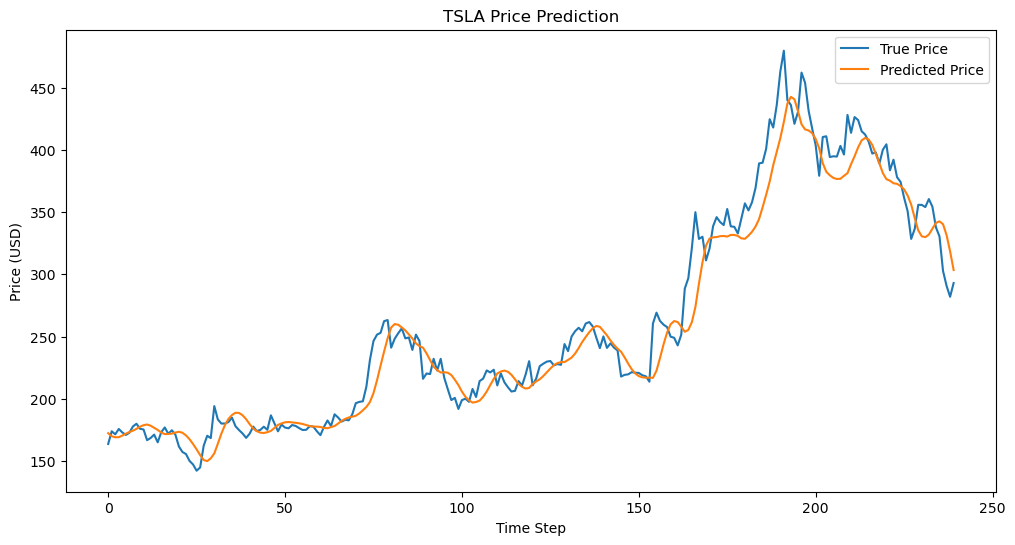

In [8]:

# Evaluate model performance on test set
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

# Make predictions on the test set
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test_unscaled, label='True Price')
plt.plot(predictions, label='Predicted Price')
plt.title('TSLA Price Prediction')
plt.xlabel('Time Step')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


# Loss Function

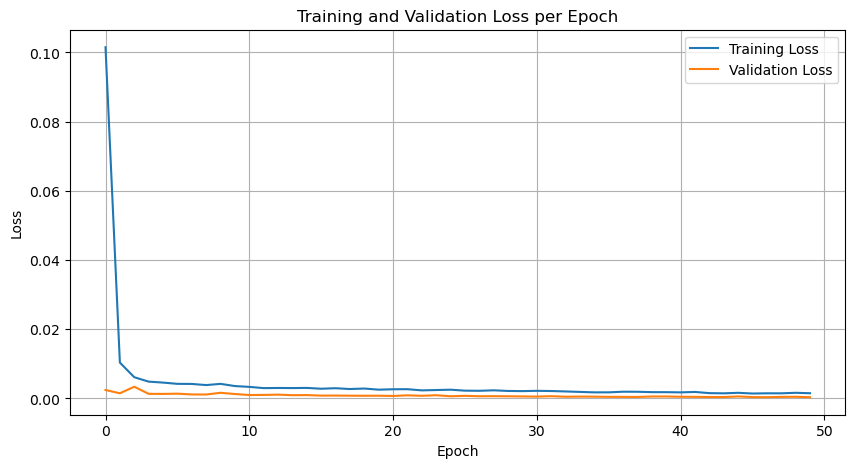

In [6]:
import matplotlib.pyplot as plt

# Plot the training and validation loss values from the history object
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# Predicting 30 days in the future

In [4]:
# Number of future days to predict (e.g., one month = 30 days)
future_steps = 30

# Start with the last 'window_size' days from our scaled data as the initial input sequence.
# We use the entire dataset's last sequence, but you could also use the last sequence from the test set.
last_sequence = scaled_prices[-window_size:].copy()

# Initialize an empty list to store our future predictions.
future_predictions = []

# Iteratively predict one day at a time and update the sequence for the next prediction.
for _ in range(future_steps):
    # Reshape the current sequence to match the input shape expected by the LSTM: [samples, time steps, features]
    input_seq = last_sequence.reshape(1, window_size, 1)
    
    # Predict the next value using the trained model.
    next_value_scaled = model.predict(input_seq)[0][0]
    
    # Append the predicted value to our list of future predictions.
    future_predictions.append(next_value_scaled)
    
    # Update the sequence by removing the first value and appending the new prediction at the end.
    last_sequence = np.append(last_sequence[1:], [[next_value_scaled]], axis=0)

# Inverse transform the scaled predictions back to the original price range.
future_predictions_unscaled = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Print the future predictions
print("Predicted future values for the next 30 days:")
print(future_predictions_unscaled)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

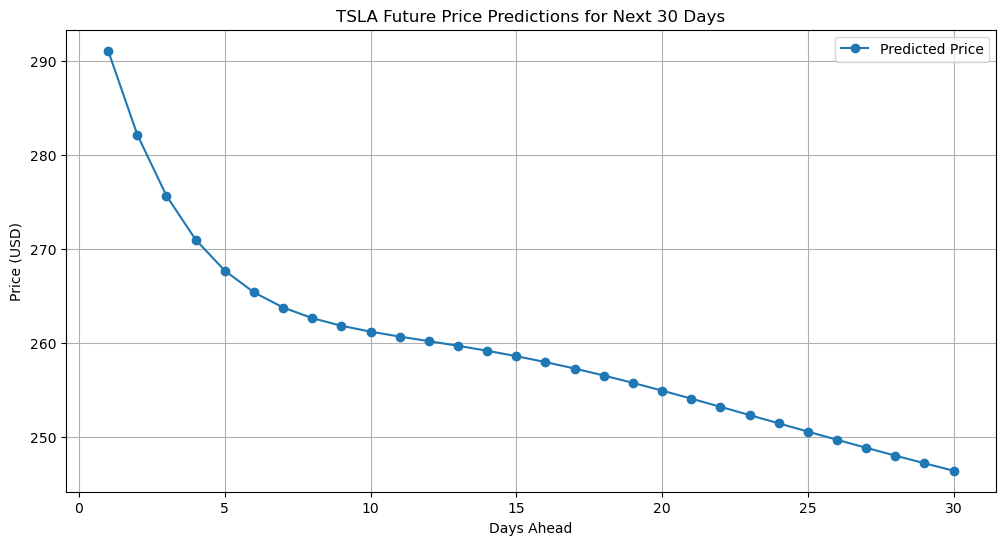

In [5]:
import matplotlib.pyplot as plt

# Create an array for the x-axis representing each future day (1 to future_steps)
future_days = np.arange(1, future_steps + 1)

# Plot the predicted future values
plt.figure(figsize=(12, 6))
plt.plot(future_days, future_predictions_unscaled, marker='o', linestyle='-', label='Predicted Price')
plt.title("TSLA Future Price Predictions for Next 30 Days")
plt.xlabel("Days Ahead")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


# Code for cross validation

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Define a function that creates a new instance of the RNN model
def create_model(window_size):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(window_size, 1)),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Set up TimeSeriesSplit for cross-validation (e.g., 5 splits)
tscv = TimeSeriesSplit(n_splits=5)

# List to store validation loss for each fold
val_losses = []

# Loop through each split of the training data
for fold, (train_index, val_index) in enumerate(tscv.split(X_train)):
    print(f"Training fold {fold+1}")
    
    # Split the data into current fold's training and validation sets
    X_train_cv, X_val_cv = X_train[train_index], X_train[val_index]
    y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]
    
    # Create a new model instance for each fold
    model_cv = create_model(window_size)
    
    # Setup EarlyStopping to monitor validation loss for the current fold
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Train the model on the current fold's training data
    history_cv = model_cv.fit(
        X_train_cv, y_train_cv,
        epochs=50,
        batch_size=32,
        validation_data=(X_val_cv, y_val_cv),
        callbacks=[early_stop],
        verbose=0  # Set verbose to 0 to reduce output clutter; change to 1 for more details
    )
    
    # Evaluate the model on the current fold's validation data
    fold_val_loss = model_cv.evaluate(X_val_cv, y_val_cv, verbose=0)
    print(f"Fold {fold+1} Validation Loss: {fold_val_loss}")
    val_losses.append(fold_val_loss)

# Calculate the average validation loss across all folds
average_val_loss = np.mean(val_losses)
print("Cross-validation validation losses:", val_losses)
print("Average validation loss:", average_val_loss)


# Other choices for optimizers
While Adam is a strong default choice, you might experiment with alternatives such as RMSprop 
or even SGD with momentum if you encounter specific issues during training. 

# Complete Hypertuning